In [2]:
import sys
import os
sys.path.append(os.path.relpath('../../'))
import numpy as np
from multi_condensed import Problem
from math import sqrt, cosh, cos, sinh, sin, pi, exp
from multi_condensed import Problem
from scipy import integrate
import capytaine as cpt
import time

from scipy.special import iv as besseli
from scipy.special import kv as besselk
from scipy.special import ive as besselie
from scipy.special import kve as besselke
from numpy import inf

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

In [3]:
# solve regular MEEM
def solve_MEEM(h, d, a, heaving, NMK, m0, rho):
  prob = Problem(h, d, a, heaving, NMK, m0, rho)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  am, dp = prob.hydro_coeffs(x, "capytaine")
  return prob, cs, am, dp

# get slope in each region.
def get_slopes(d_in, d_out, a):
  slopes = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]:
      slopes.append(0)
    elif i == 0: # inner radius is 0
      slopes.append((d_in[i] - d_out[i])/a[i])
    else:
      slopes.append((d_in[i] - d_out[i])/(a[i] - a[i - 1]))
  return slopes

def make_slant_region(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
     d_in_prime.append(d1 + i * delta_d)
     d_out_prime.append(d1 + (1 + i) * delta_d)
  return a_prime, d_prime, d_in_prime, d_out_prime

# given an outline, create approximating box-MEEM inputs
def slant_approx_vars(a, d_in, d_out, heaving, NMK, res):
  a_prime = []
  d_prime = []
  # d_in_prime = []
  # d_out_prime = []
  heaving_prime = []
  NMK_prime = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        # d_in_prime.append(d_in[i])
        # d_out_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add, d_in_add, d_out_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
      #  d_in_prime += d_in_add
      #  d_out_prime += d_out_add
  NMK_prime.append(NMK[-1])
  return a_prime, d_prime, heaving_prime, NMK_prime

In [5]:
h = 15
a = [2, 4, 6]
heaving = [1, 1, 1]
NMK = [50, 50, 50]
m0 = 0.9
rho = 1023

outer_region_depths = [6, 5, 4, 3, 2]

configurations = []
for slant_end_depth in [3, 5]:
  for depth in outer_region_depths:
    d_in = [7, 4, depth]
    d_out = [7, slant_end_depth, depth]
    if slant_end_depth == 3:
      slant_type = "up"
    else:
      slant_type = "down"
    config = {"name" : slant_type + "-depth-" + str(depth),
              "d_in" : d_in,
              "d_out" : d_out}
    configurations.append(config)

In [43]:
res = 40

for config in configurations:
  a_prime, d_prime, heaving_prime, NMK_prime = slant_approx_vars(a, config["d_in"], config["d_out"], heaving, NMK, res)
  prob, cs, am, dp = solve_MEEM(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)
  config["AM"] = am
  config["DP"] = dp

  regions = range(1, res + 1)
  i_type = np.zeros((res, NMK[1]), dtype=complex)
  k_type = np.zeros((res, NMK[1]), dtype=complex)
  for region in regions:
    for m in range(NMK[1]):
      i_type[region - 1, m] = cs[region][m]
      k_type[region - 1, m] = cs[region][m + NMK[1]]
  
  config["I0 Array"] = i_type
  config["K0 Array"] = k_type

  scale_function_i1 = lambda i, m, x: (besseli(0, prob.lambda_ni(m, i) * a_prime[i]) * x)/(besseli(0, prob.lambda_ni(m, 1) * a_prime[1]) * i_type[0][m])
  scale_function_i2 = lambda i, m, x: x/i_type[0][m]
  scale_function_k1 = lambda i, m, x: (besselk(0, prob.lambda_ni(m, i) * a_prime[i]) * x)/(besselk(0, prob.lambda_ni(m, 1) * a_prime[1]) * k_type[0][m])
  scale_function_k2 = lambda i, m, x: x/k_type[0][m]

  i_type_scaled1 = np.array([[scale_function_i1(i, j, val) for j, val in enumerate(row)]
                    for i, row in enumerate(i_type)])
  i_type_scaled2 = np.array([[scale_function_i2(i, j, val) for j, val in enumerate(row)]
                      for i, row in enumerate(i_type)])
  k_type_scaled1 = np.array([[scale_function_k1(i, j, val) for j, val in enumerate(row)]
                      for i, row in enumerate(k_type)])
  k_type_scaled2 = np.array([[scale_function_k2(i, j, val) for j, val in enumerate(row)]
                      for i, row in enumerate(k_type)])
  config["I0 Full Scale Array"] = i_type_scaled1
  config["I0 Direct Scale Array"] = i_type_scaled2
  config["K0 Full Scale Array"] = k_type_scaled1
  config["K0 Direct Scale Array"] = k_type_scaled2
  config["Problem"] = prob

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_89332/952343900.py:22: RuntimeWarning: invalid value encountered in scalar multiply
  scale_function_k1 = lambda i, m, x: (besselk(0, prob.lambda_ni(m, i) * a_prime[i]) * x)/(besselk(0, prob.lambda_ni(m, 1) * a_prime[1]) * k_type[0][m])
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_89332/952343900.py:22: RuntimeWarning: invalid value encountered in scalar divide
  scale_function_k1 = lambda i, m, x: (besselk(0, prob.lambda_ni(m, i) * a_prime[i]) * x)/(besselk(0, prob.lambda_ni(m, 1) * a_prime[1]) * k_type[0][m])
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_89332/952343900.py:23: RuntimeWarning: invalid value encountered in scalar divide
  scale_function_k2 = lambda i, m, x: x/k_type[0][m]


In [28]:
def plot_many_scaled(arr, regions, coeff_range, bessel_type):
  cmap = get_cmap('Blues')
  interval = 0.7/coeff_range[-1]
  colors = [cmap(0.3 + interval * i) for i in range(coeff_range[-1] + 1)]
  for m in coeff_range:
    plt.plot(regions, arr [:, m], color = colors[m], label = str(m))
  # Labels and title
  plt.xlabel('region #')
  plt.ylabel('value')
  # plt.legend()
  plt.title('coeff of ' + bessel_type + ' bessel function, by region, for various m, rescaled')
  plt.grid(True)
  plt.show()

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_89332/3576798075.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Bimali/Desktop/SEALab/semi-analytical-hydro/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


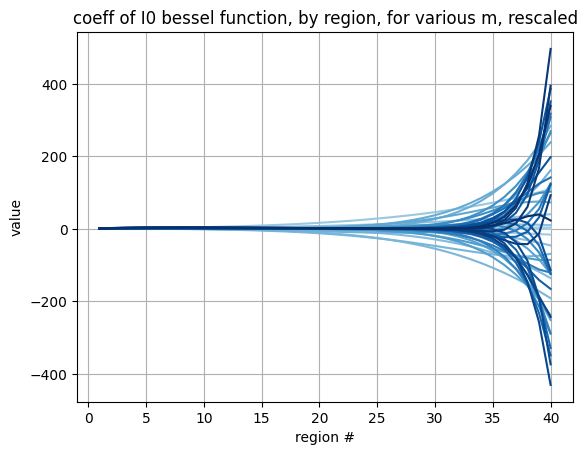

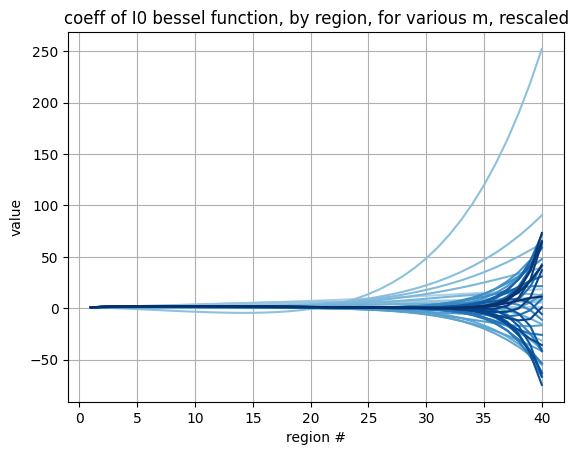

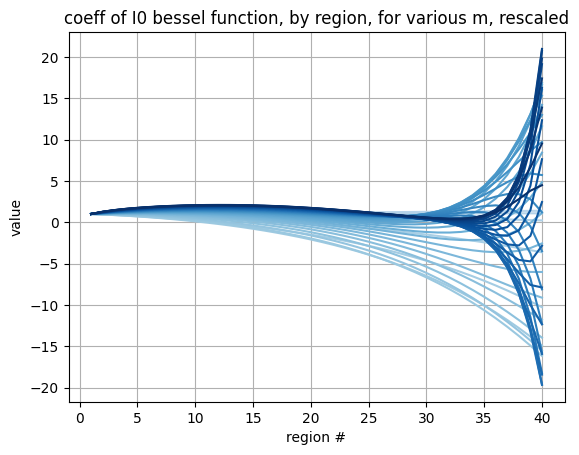

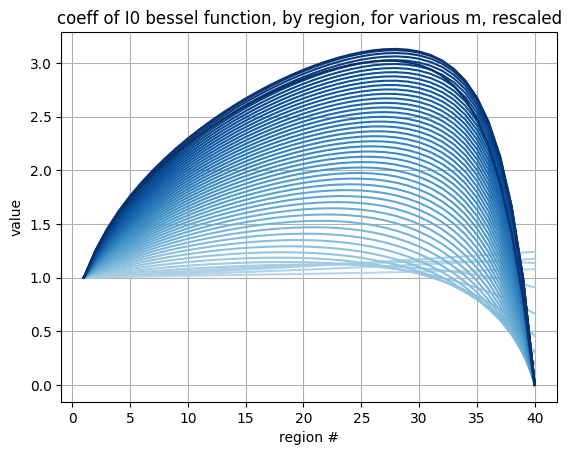

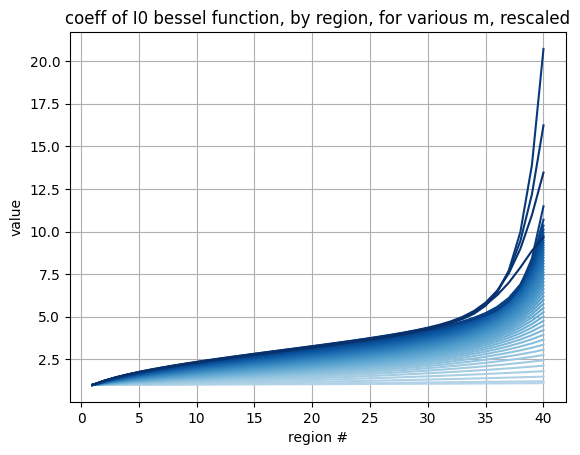

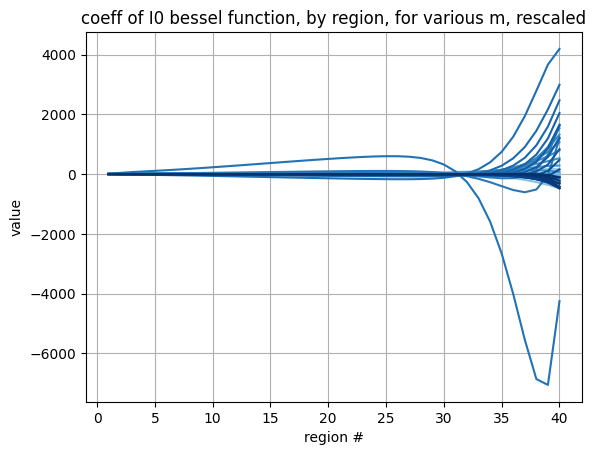

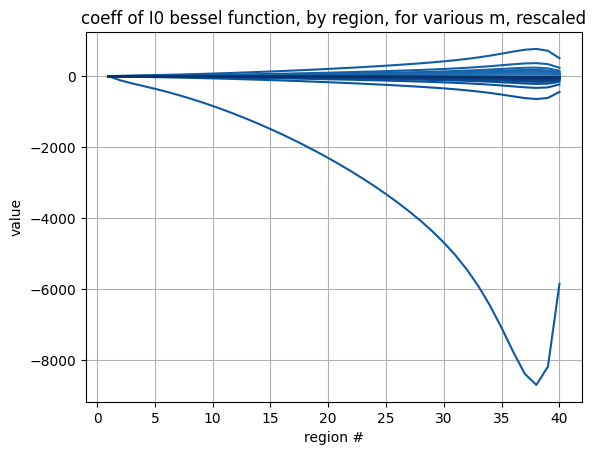

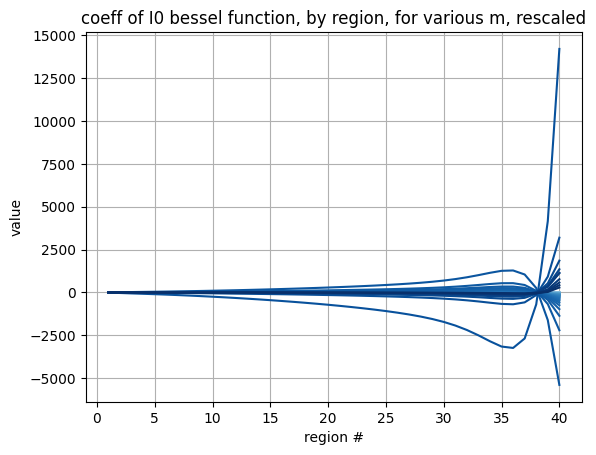

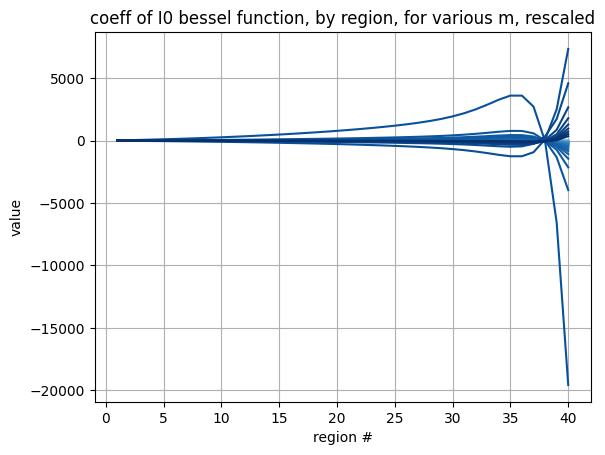

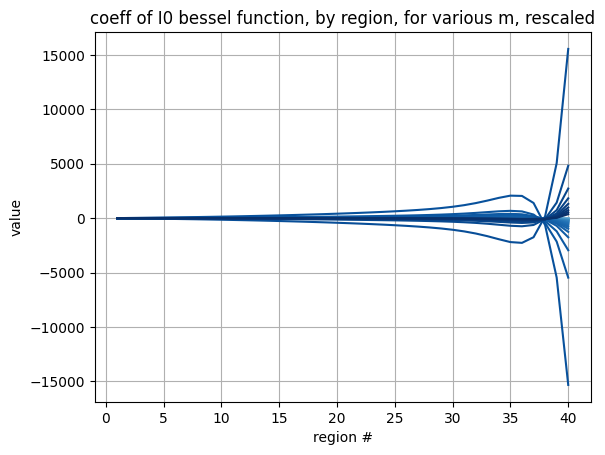

In [44]:
regions = range(1,41)
coeff_range = range(50)
for config in configurations:
  plot_many_scaled(config["I0 Direct Scale Array"], regions, coeff_range, "I0")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_89332/3576798075.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')


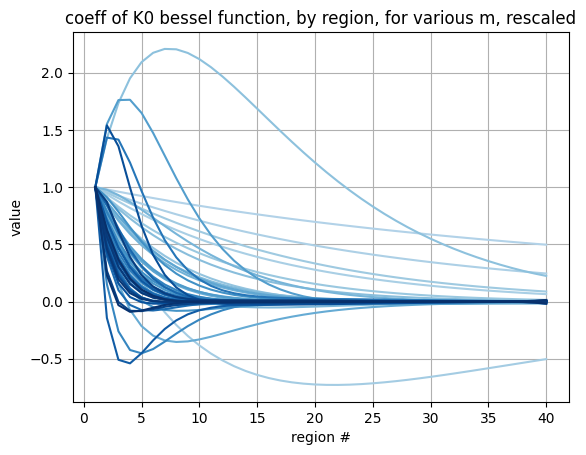

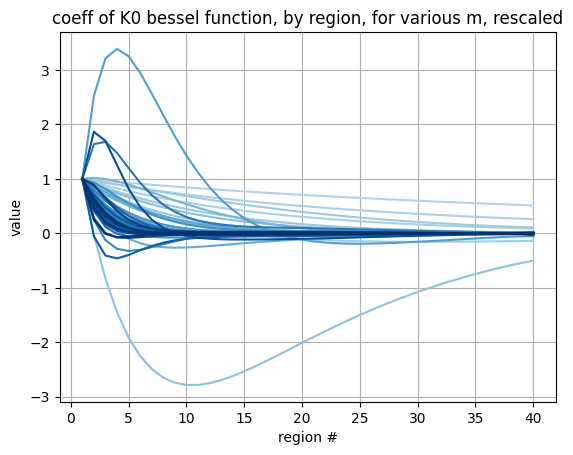

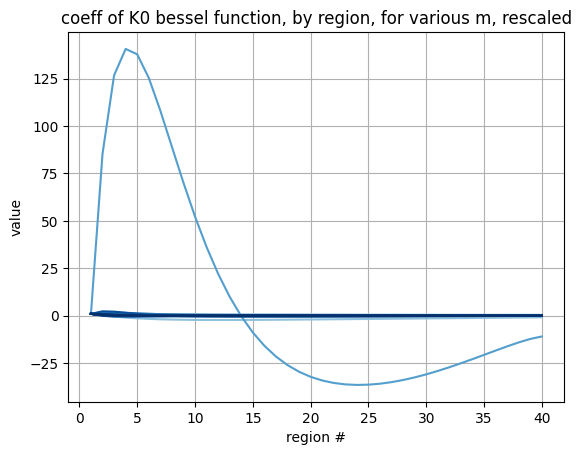

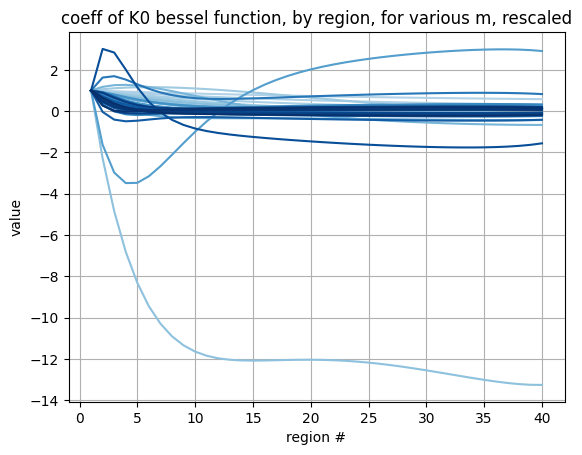

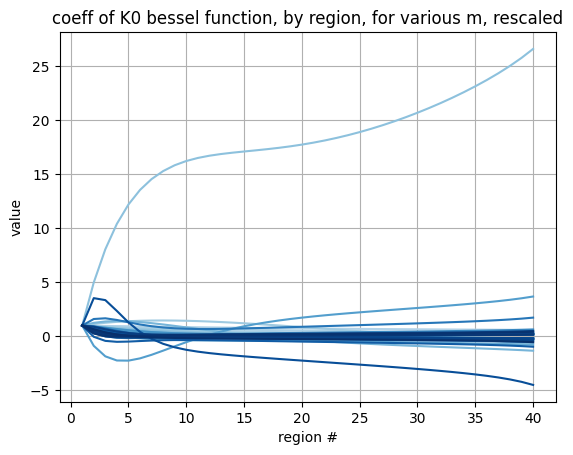

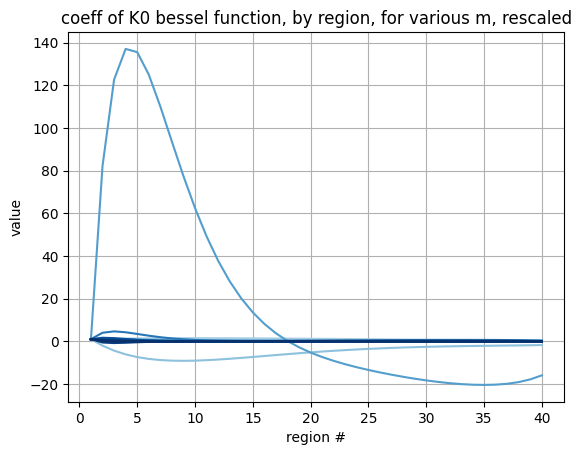

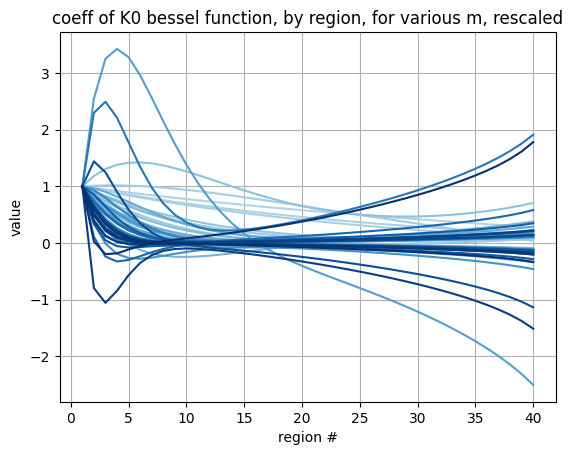

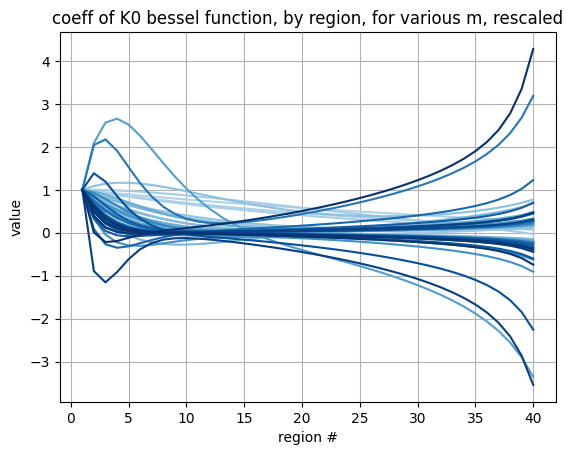

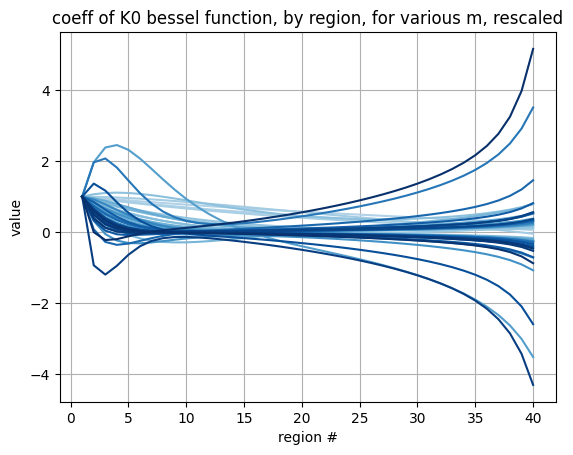

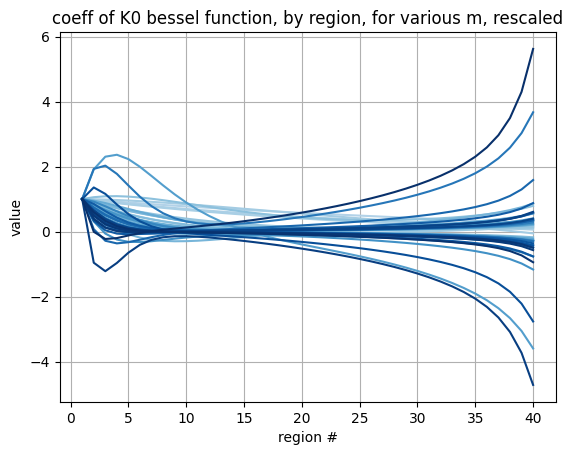

In [45]:
regions = range(1,41)
coeff_range = range(50)
for config in configurations:
  plot_many_scaled(config["K0 Direct Scale Array"], regions, coeff_range, "K0")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_89332/3576798075.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')


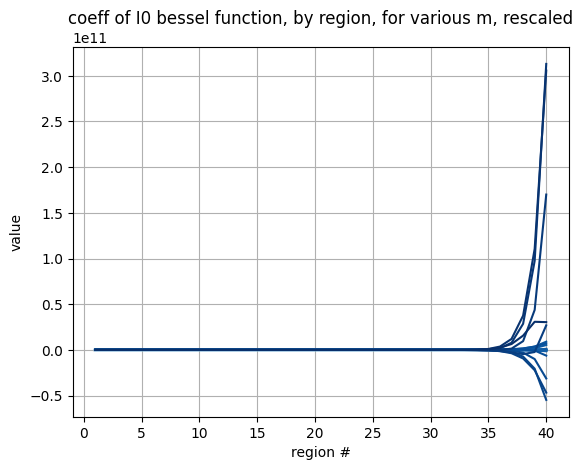

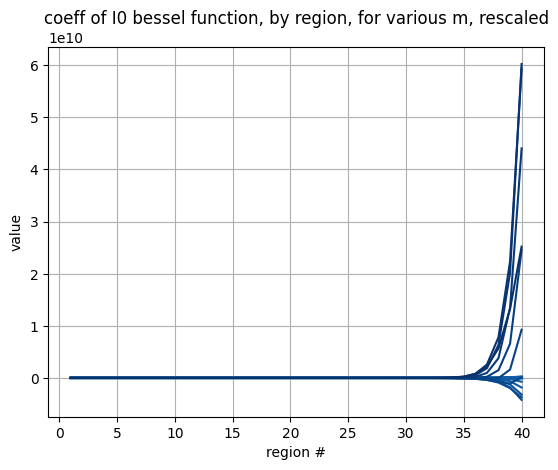

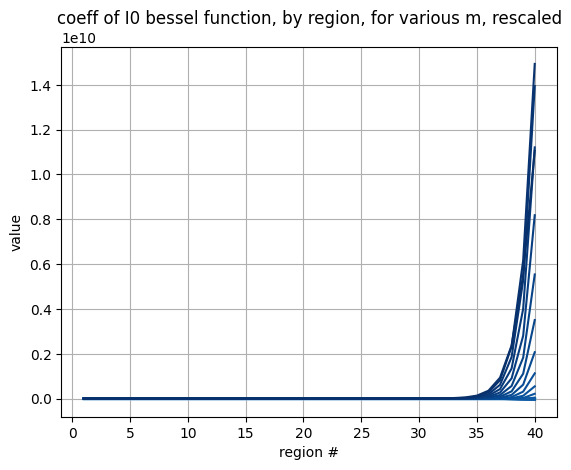

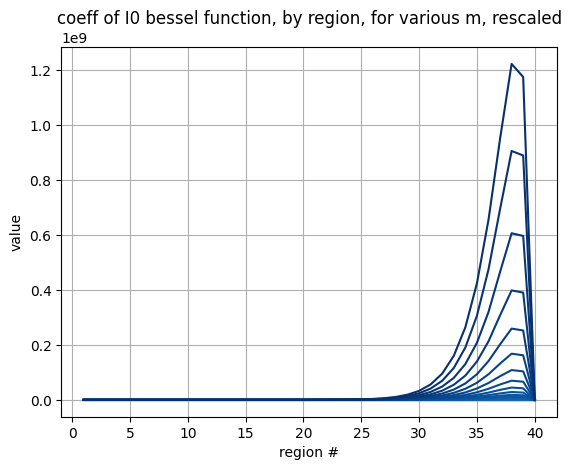

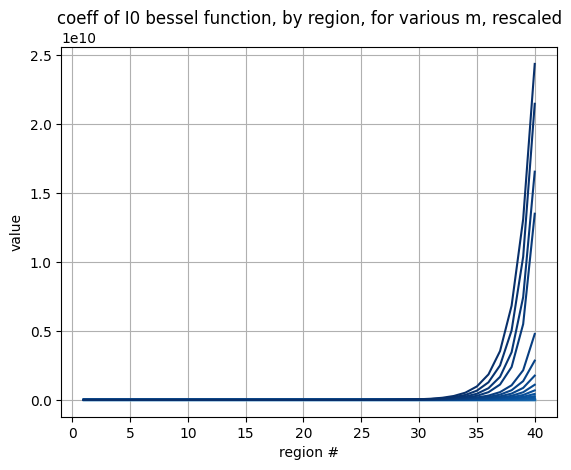

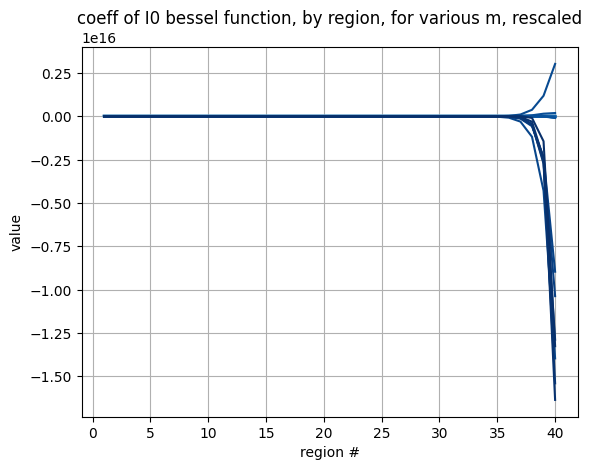

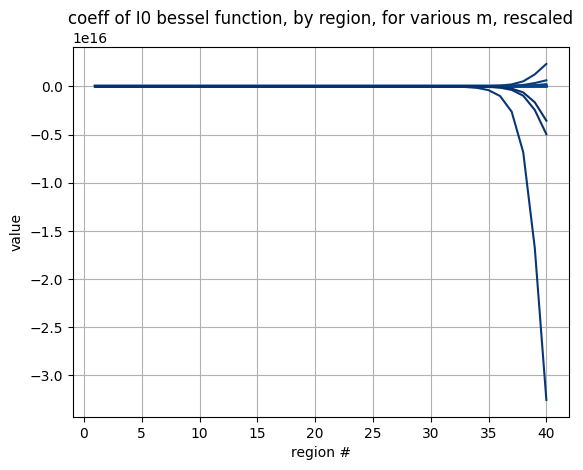

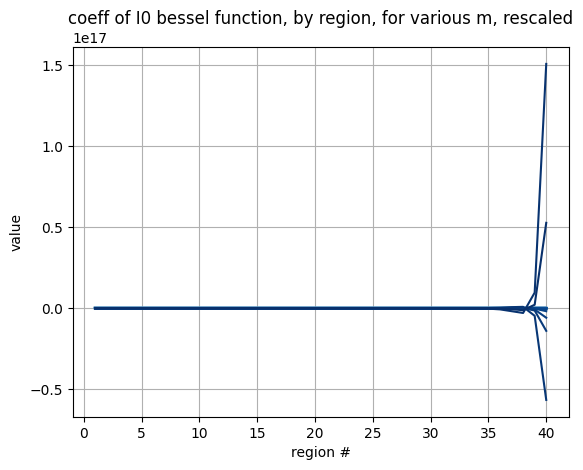

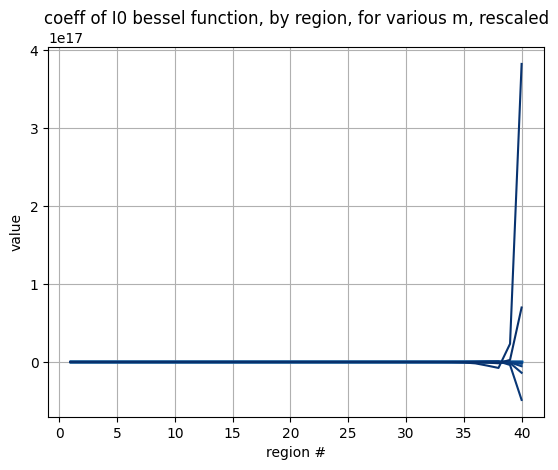

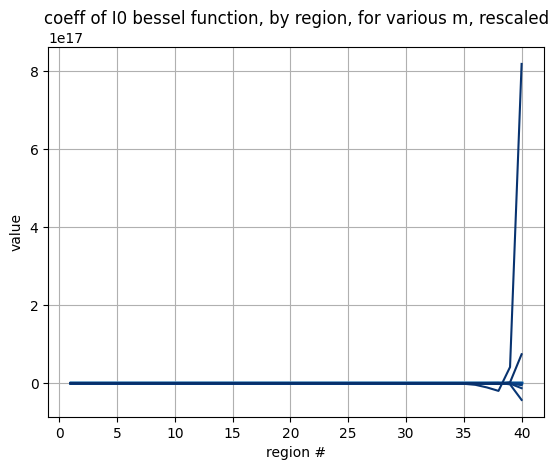

In [38]:
regions = range(1,41)
coeff_range = range(50)
for config in configurations:
  plot_many_scaled(config["I0 Full Scale Array"], regions, coeff_range, "I0")

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_89332/3576798075.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Blues')


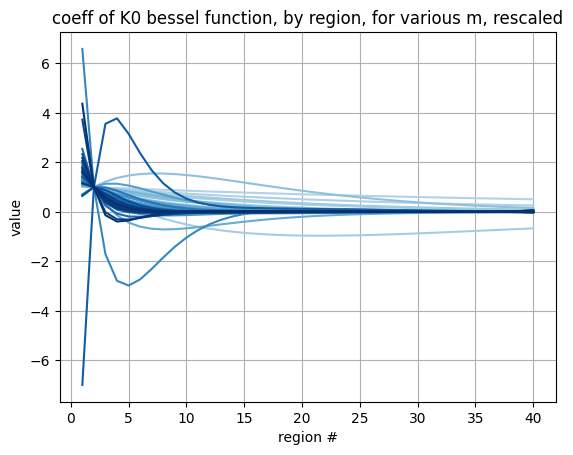

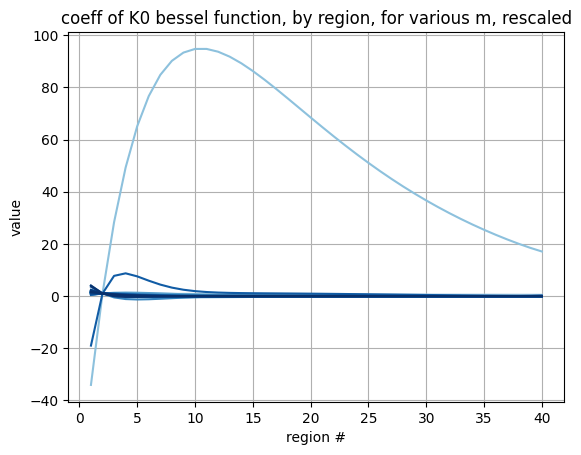

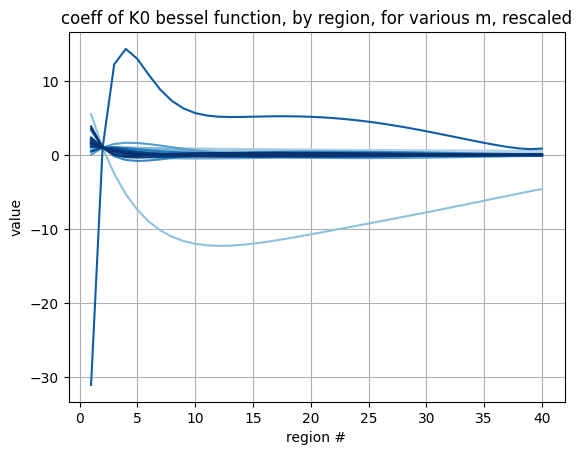

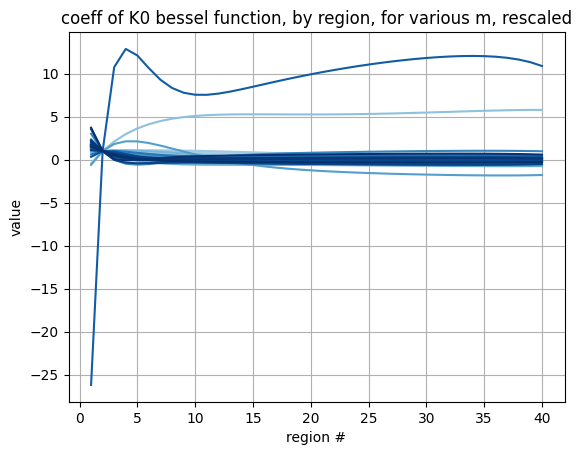

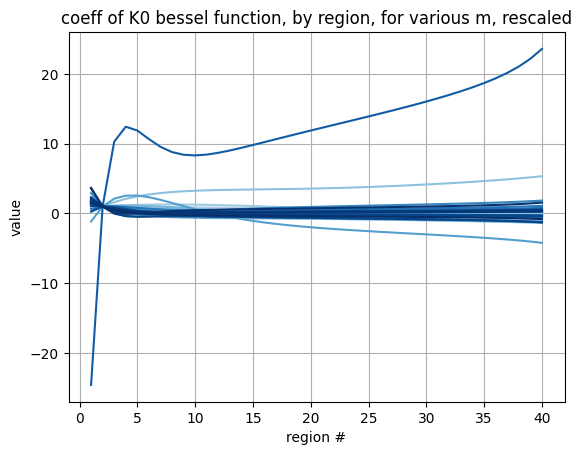

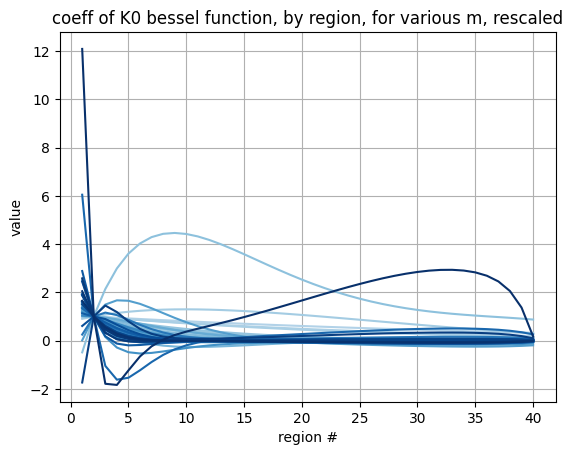

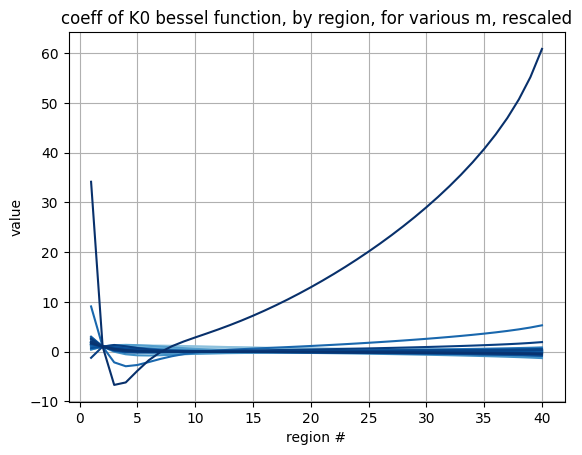

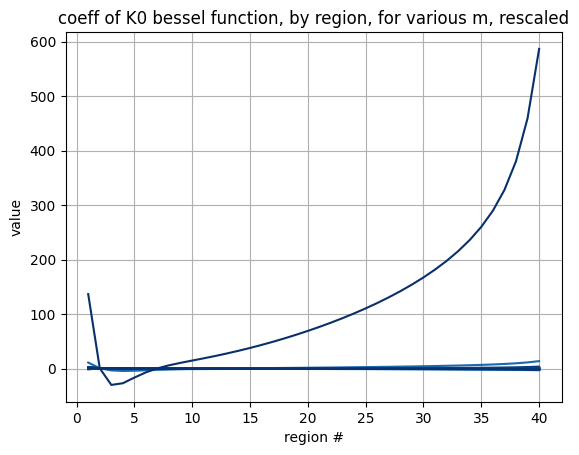

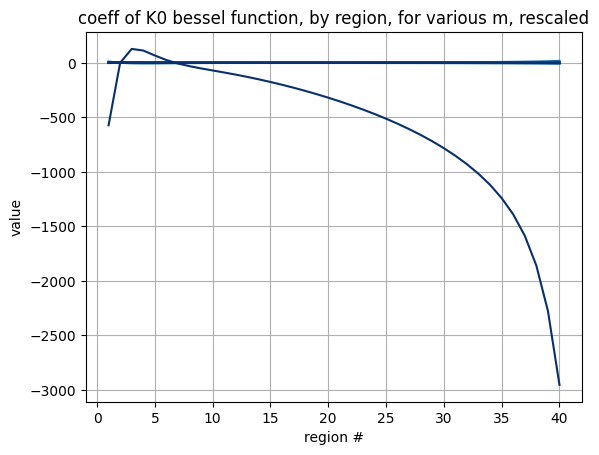

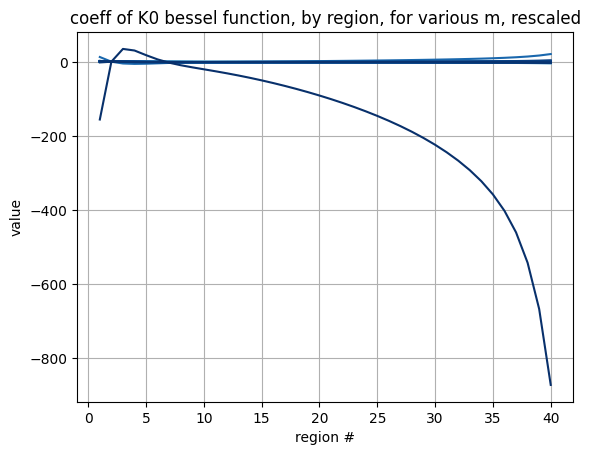

In [39]:
regions = range(1,41)
coeff_range = range(50)
for config in configurations:
  plot_many_scaled(config["K0 Direct Scale Array"], regions, coeff_range, "K0")

In [ ]:
def remap_scaling(fun_i, fun_k, name, config):
    i_type = config["I0 Array"]
    k_type = config["K0 Array"]

    i_type_scaled = np.array([[fun_i(i, j, val) for j, val in enumerate(row)] for i, row in enumerate(i_type)])
    k_type_scaled = np.array([[fun_k(i, j, val) for j, val in enumerate(row)] for i, row in enumerate(k_type)])
    config["I0 " + name + " Array"] = i_type_scaled
    config["K0 " + name + " Array"] = k_type_scaled